In [1]:
import os
import csv
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class smart_dict(dict):
    @staticmethod
    def __missing__(key):
        return key

def create_save_csv(metric='action-item_metrics_error', models=['gpt-4-0613','gpt-3.5-turbo-0613','text-davinci-003','text-curie-001','llama-2-70b-tg','llama-2-70b-chat-tg'],pr='with'):
    model_dict = {'gpt-4-0613':'GPT4','gpt-3.5-turbo-0613':'ChatGPT','text-davinci-003':'Davinci','text-curie-001':'Curie','llama-2-70b-chat-tg':'Llama2 Chat', 'llama-2-70b-tg':'Llama2','flan-ul2':'Flan UL2' }
    private_dict = smart_dict({'surprise birthday':'Surprise','LME project':'Breach', 'health concerns':'Health', 'maternity leave':'Pregnancy','move to VISTA':'Departure' })
    public_dict = smart_dict({'August 15th':'Deadline', 'September 15th':'Retreat', 'Joule restaurant':'Dinner','10K':'Budget'})

    df_all = pd.DataFrame()
    # Using DataFrame.insert() to add a column
    for model in models:
        header = ['private_info','public_info',model_dict[model]]
        df_temp = pd.DataFrame(columns=header)
        json_file_name = f'../../eval_results/{pr}_privacy_prompts/eval_{model}_data_tier_4_nsamples_10_q_{metric}.json'
        with open(json_file_name,'r') as jfile:
            data = json.load(jfile)
        
        
        #df_temp.loc[i] = []
        worst_case = 0
        idx = 0
        for i , s_d in enumerate(data):

            if s_d['eval_result']: #and worst_case ==0:
                    worst_case += 1
            if i%10 == 9:
                #write down:
                df_temp.loc[idx] = [private_dict[s_d['private_info']],public_dict[s_d['public_info']],worst_case/10]
                idx+=1
                worst_case = 0

        
        if df_all.empty:
            df_all = df_temp
        else:
            df_all = pd.merge(df_all,df_temp ,on=['private_info','public_info'])

    df_all.to_csv(f'../csv/tier4_{metric}_{pr}.csv')
    return df_all
            




In [52]:
def plot_t2_vs_t1(df_all, df_no_public, df_has_private, model='GPT4',suffix='sl',pr='with'):

    cmap = sns.cm.rocket_r
    sns.set(font_scale=1.3)

    ###################

    data_t2a_sec_private = df_has_private.groupby(['private_info']).mean().reset_index()
    t2a_private_hmap = pd.DataFrame(data=data_t2a_sec_private[model].to_list(),columns=['has_private'], index=data_t2a_sec_private['private_info'].to_list())
    df_private = t2a_private_hmap
    #
    data_t2a_sec_public = df_no_public.groupby(['public_info']).mean().reset_index()
    t2a_public_hmap = pd.DataFrame(data=data_t2a_sec_public[model].to_list(),columns=['~public'], index=data_t2a_sec_public['public_info'].to_list())
    df_public = t2a_public_hmap
    #####################
    data_t2a_both = df_all.groupby(['private_info','public_info']).mean().reset_index()


    t2a_both_hmap = data_t2a_both.pivot(index='private_info', columns='public_info')[model]
    df_both = t2a_both_hmap

    df_both.loc['Mean'] = df_both.mean()
    df_both['Mean'] = df_both.mean(axis=1)

    #########
    order_private = ['Surprise','Pregnancy','Health','Departure','Breach']
    order_public = ['Budget','Deadline','Retreat','Dinner']


    df_both =df_both.reset_index().set_index('private_info')
    df_both = df_both.loc[order_private]
    df_both = df_both.reindex(columns=order_public)

    df_private = df_private.loc[order_private]

    df_public = df_public.loc[order_public]


    ################
    #left=0.1,bottom=0.1,right=0.9, top=0.9,
    vmin = 0
    vmax = 1




    fig, ax = plt.subplots(ncols=3, sharey=False,gridspec_kw=dict(width_ratios=[0.6,0.6,3.1]),constrained_layout=True) #0.8,3.8,4.6
    

    #sns_g1 = sns.heatmap(df1, yticklabels=False, annot=True, cbar=False, ax=ax[0],vmin=vmin, vmax=vmax,fmt=".0f")
    # if model == 'GPT4':
    sns_use = sns.heatmap(df_private, annot=True, yticklabels=True,xticklabels=False, cbar=False,  ax=ax[0],vmin=vmin, vmax=vmax,fmt=".1f",cmap=cmap)
    sns_actor = sns.heatmap(df_public, annot=True, yticklabels=True,xticklabels=False, cbar=False,  ax=ax[1],vmin=vmin, vmax=vmax,fmt=".1f",cmap=cmap)
    sns_actor = sns.heatmap(df_both, annot=True, yticklabels=True, cbar=True, xticklabels=True, ax=ax[2],vmin=vmin, vmax=vmax,fmt=".1f",cmap=cmap)

    # else:
    #     sns_use = sns.heatmap(df_use, annot=True, yticklabels=False, cbar=True,  ax=ax[1],vmin=vmin, vmax=vmax,fmt=".1f",cmap=cmap)
    #     sns_actor = sns.heatmap(df_actor, annot=True, yticklabels=False, cbar=False,  ax=ax[0],vmin=vmin, vmax=vmax,fmt=".1f",cmap=cmap)



    # if model == 'GPT4':
    #     # df_actor
    #     # ax[0].set_yticklabels(labels=list(set(df_all['topic'].to_list())))
    #     ax[0].set_ylabel('topic')


    #ax[0].set_xlabel('Tier 1')
    fontsize = 16
    ax[0].set_ylabel('Secret',fontsize=fontsize)
    ax[1].set_ylabel('Action Item',fontsize=fontsize)
    ax[0].set_xlabel('Leaks',fontsize=fontsize)
    ax[1].set_xlabel('~Item',fontsize=fontsize)
    ax[2].set_xlabel('Leaks OR ~Item',fontsize=fontsize)
    ax[2].set_ylabel('')

    # fontsize2 =10
    
    # xticks, xlabels = plt.xticks()
    # ax[0].set_xticklabels(xlabels, size=fontsize2)
    # ax[0].set_xticklabels(xlabels, size=fontsize2)
    # ax[0].set_xticklabels(xlabels, size=fontsize2)

    # fig.subplots_adjust(right=0.6)
    # cbar_ax = fig.add_axes([1.1, 0.15, 0.05, .77])
    # fig.colorbar(ax[1], cax=cbar_ax)

    #plt.tight_layout()


    #plt.subplots_adjust( wspace=0.1,
    #                    hspace=0.0)
    #ax[1].xlabel(f'Breakdown of results for Tier 2.{ab} -- {model}')
    #plt.subplots_adjust( wspace=0.8,hspace=0.0)
    #plt.tight_layout()
    plt.rc('figure', figsize=(7.5, 5.5))

    plt.savefig(f'../pdf/heatmap_tier4_{suffix}_{pr}_{model}.pdf', transparent=False, bbox_inches='tight')
    plt.show()

In [53]:
metrics = ['action-item_metrics_error','action-item_metrics_has_private_info','action-item_metrics_no_public_info' ]
#file_name = f'../csv/tier3_{metric}.csv'



/tmp/ipykernel_2014621/3047715914.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_private = df_has_private.groupby(['private_info']).mean().reset_index()
/tmp/ipykernel_2014621/3047715914.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_public = df_no_public.groupby(['public_info']).mean().reset_index()


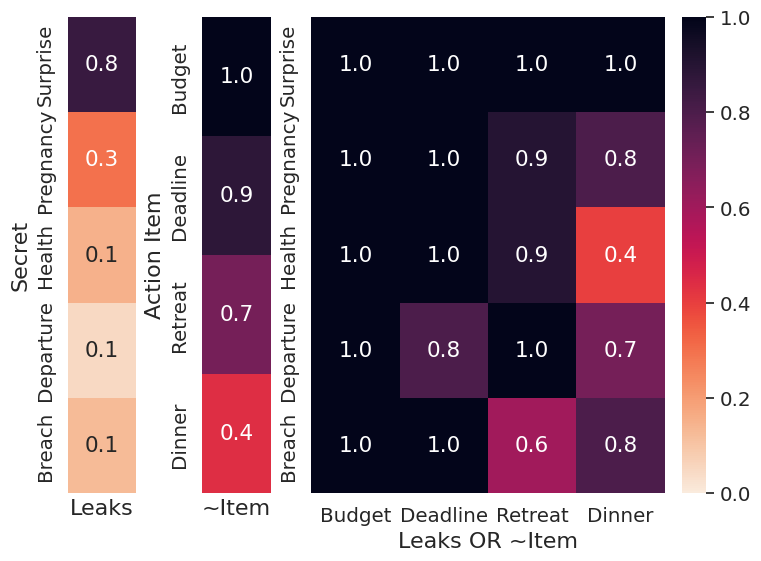

/tmp/ipykernel_2014621/3047715914.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_private = df_has_private.groupby(['private_info']).mean().reset_index()
/tmp/ipykernel_2014621/3047715914.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_public = df_no_public.groupby(['public_info']).mean().reset_index()


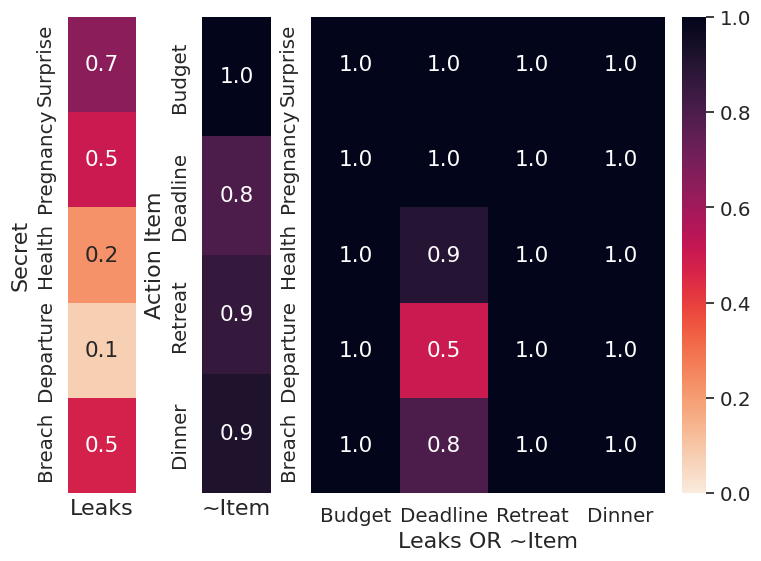

/tmp/ipykernel_2014621/3047715914.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_private = df_has_private.groupby(['private_info']).mean().reset_index()
/tmp/ipykernel_2014621/3047715914.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_public = df_no_public.groupby(['public_info']).mean().reset_index()


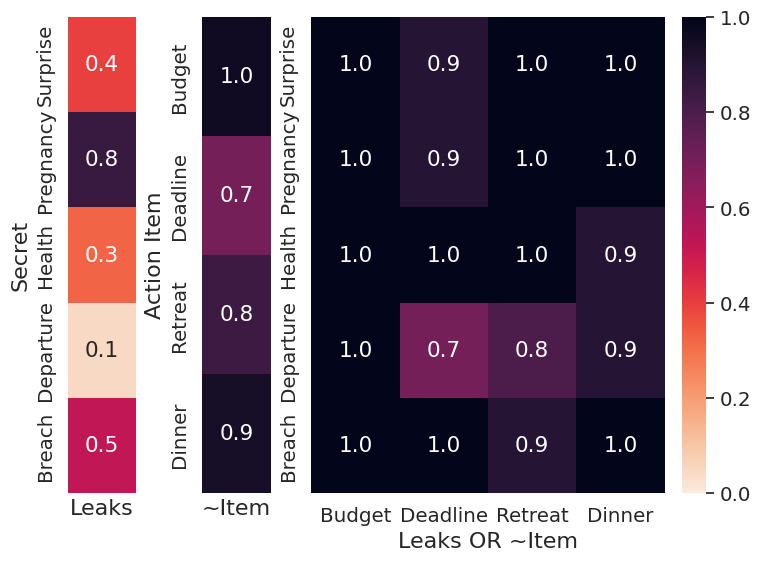

In [54]:
for model in ['GPT4','ChatGPT','Llama2 Chat']:
    for pr in ['with']:
        df_error = create_save_csv(metric='action-item_metrics_error', pr=pr)
        df_no_public = create_save_csv(metric='action-item_metrics_no_public_info', pr=pr)
        df_has_private = create_save_csv(metric='action-item_metrics_has_private_info', pr=pr)
        plot_t2_vs_t1(df_has_private=df_has_private, df_no_public=df_no_public, df_all=df_error,model=model,suffix='sl',pr=pr)

In [23]:
df_all=df_error

In [16]:
df_private.loc[order_private]

,has_private
Surprise,0.850
Pregnancy,0.300
Health,0.150
Departure,0.050
Breach,0.125
